# FEniCS hands-on high-speed course...

## Objectives
* Get to know FEniCS version 2018.1.0
* Get your hands to use with some basic study cases...
    * [ ] Learn the prototyping philosophy 
    * [ ] Learn the features of FEniCS such as UFL, CSG, PETSc, etc.
    * [ ] Get yourself dirty with Python 😳

# What is FEniCS
![FEniCS_INTRO](ImagesForSlices/Intro_FEniCS.png)

# It's quite a complex project...
![FEniCS_OVERVIEW](ImagesForSlices/Overview_FEniCS.png)

# Who am I?
> **I'm Reidmen, a curious person...** 



> Find me at: 
> * Mail *reidmen at dim.uchile.cl*
> * Blog *reidmen.github.io/PublicMistakes/*
> * LinkedIn *linkedin.com/in/reidmen-arostica*
> * Github *github.com/Reidmen*

## The idea of prototyping...

To fully model problems:
* **Where?** What is our domain of interest? ``Meshes``
* **Who?** What physical behavior we are interest in? ``Variational Formulations``
* **How?** We want easy-to-implement models, not production code... ``FEniCS``

# Learn by examples
Hopefully everyone has FEniCS already installed...

In [2]:
# Build-in 2d and 3d meshes without mshr
import dolfin as dl # The main library that gives us access to everything!
from IPython.display import HTML
%matplotlib inline
import mshr as mh
from math import cos, sin, pi

sh_outer = mh.Sphere(dl.Point(0.0,0.0,0.0), 1)
sh_inner = mh.Sphere(dl.Point(cos(25/180*pi), 0, sin(25/180*pi)), 0.2)
sh_inner_inner = mh.Sphere(dl.Point(0., 0., 0.0), 0.5)
death_star = sh_outer - sh_inner - mh.Box(dl.Point(-1, -1, -0.1), dl.Point(1, 1, 0.1)) + sh_inner_inner
#mesh = mh.generate_mesh(death_star, 20)
#HTML(dl.X3DOM.html(mesh))

#box_mesh = dl.BoxMesh(dl.Point(0.0, 0.0, 0.0),
#                      dl.Point(1.0, 1.0, 1.0),
#                      5, 5, 5)
#HTML(dl.X3DOM.html(mesh))

In [34]:
import mshr as mh
from math import cos, sin, pi

circle = mh.Circle(dl.Point(0., 0.), 1)
mesh = mh.generate_mesh(circle, 30)

# Refine it
subdomains = dl.MeshFunction("bool", mesh, 2)
subdomains.set_all(False)

angles = [angle/180*pi for angle in range(0, 360, 90)]
for angle in angles:
    cpp_expression = 'pow(x[0] - x_0, 2) + pow(x[1] - x_1, 2) <= pow(r, 2)'
    subdomain = dl.CompiledSubDomain(cpp_expression, 
                                    x_0 = 0.5*cos(angle),
                                    x_1 = 0.5*sin(angle),
                                    r = 0.1)
    subdomain.mark(subdomains, True)
    
mesh = dl.refine(mesh, subdomains)
#HTML(dl.X3DOM.html(mesh))

In [ ]:
# Creating 3D meshes with mshr (CSG)
import mshr as mh
from math import pi, sin, cos

# Step 1 --> Sphere
# Step 2 --> Hollow Sphere

# Define radii and parameters
# Step 1
R, r = 1, 0.3
# Step 2 and Step 3
angles = [0, 90, 180, 270] # degrees
x = [R*cos(float(angle) / 180 * pi) for angle in angles]
y = [0 for angle in angles]
z = [R*sin(float(angle) / 180 * pi) for angle in angles]

# Create geometry
Sh_outer = mh.Sphere(dl.Point(0., 0., 0.), R)
Sh_inners = [mh.Sphere(dl.Point(x[_], y[_], z[_]), r) for _ in range(4)]
geometry = Sh_outer - Sh_inners[0] - Sh_inners[1] - \
           Sh_inners[2] - Sh_inners[3]

# Create mesh at each iteration
mesh = mh.generate_mesh(geometry, 10)
    

HTML(dl.X3DOM.html(mesh))

In [6]:
import dolfin as dl

# Define mesh and functional space
mesh = dl.UnitSquareMesh(5, 5)
dl.File("Heat_Sol/Mesh_Test.xml") << mesh

# Open file and visualize syntax
with open("Heat_Sol/Mesh_Test.xml", "r+") as mesh_file:
    print(mesh_file.read())

<?xml version="1.0"?>
<dolfin xmlns:dolfin="http://fenicsproject.org">
  <mesh celltype="triangle" dim="2">
    <vertices size="36">
      <vertex index="0" x="0.000000000000000e+00" y="0.000000000000000e+00" />
      <vertex index="1" x="2.000000000000000e-01" y="0.000000000000000e+00" />
      <vertex index="2" x="4.000000000000000e-01" y="0.000000000000000e+00" />
      <vertex index="3" x="6.000000000000000e-01" y="0.000000000000000e+00" />
      <vertex index="4" x="8.000000000000000e-01" y="0.000000000000000e+00" />
      <vertex index="5" x="1.000000000000000e+00" y="0.000000000000000e+00" />
      <vertex index="6" x="0.000000000000000e+00" y="2.000000000000000e-01" />
      <vertex index="7" x="2.000000000000000e-01" y="2.000000000000000e-01" />
      <vertex index="8" x="4.000000000000000e-01" y="2.000000000000000e-01" />
      <vertex index="9" x="6.000000000000000e-01" y="2.000000000000000e-01" />
      <vertex index="10" x="8.000000000000000e-01" y="2.000000000000000e-01" 

# Laplace System
## First, the static Poisson case
We are interested in the PDE system on a domain $\Omega \subset \mathbb{R}^2$ with noundary $\partial \Omega = \Gamma_D \cup \Gamma_N$ and sufficiently regular function $f \in C^{\infty}(\Omega)$:
\begin{equation}
\begin{aligned}
 - \nabla \cdot ( \nabla u) = f & \text{ in } \Omega \\
 u = u_D & \textit{ on } \Gamma_D \\
 \nabla u \cdot n = g & \textit{ on } \Gamma_N.
\end{aligned}
\end{equation}

Here, $f$ and $g$ denotes input data and $n$ the outward directed normal at the boundary.

## Variational Formulation
In this case, we consider a ``Trial Space`` $V$ denoting the order 1 Lagrange elements $H^1(\Omega)$-conforming, and its ``Test Space`` $\hat{V}$ of order 1 Lagrange elements with homogeneous *Dirichlet* boundary.
Thus, let us take $(u,v) \in V\times \hat{V}$, by applying integration by parts, it follows a well-defined variational formulation:
\begin{equation}
a(u,v) := \int_{\Omega} \nabla u \cdot \nabla v = \int_{\Omega} f v + \int_{\Gamma_N} g v  =: L(v) \quad \forall v \in \hat{V} 
\end{equation}

## Model Parameters
For this example, we'll consider:
* A domain $\Omega = [0,1]^2$,
* Dirichlet boundary $\Gamma_D  =\{ (0, y) \cup (1,y) \subset \partial \Omega \}$,
* Neumann boundary $\Gamma_N = \{ (x, 0) \cup (x,1) \subset \partial \Omega \}$,
* A Neumann condition in the form $g = sin(5x)$,
* A source term $f = 10 e^{-\frac{(x-0.5)^2+(y-0.5)^2}{0.02}}$.

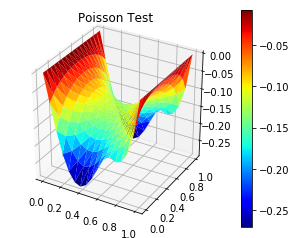

In [4]:
import dolfin as dl
from math import sin
import matplotlib.pyplot as plt
# Define mesh and functional space
mesh = dl.UnitSquareMesh(16, 16)
#File("Heat_Sol/Mesh_Test.xml") << mesh

V = dl.FunctionSpace(mesh, 'Lagrange', 1)

# Boundary conditions: Python or c++ or by MeshFunction
#def Boundary(x, on_boundary):
#    return on_boundary
def bdry(x, on_boundary):
    each_case = x[0] < dl.DOLFIN_EPS or x[0] > 1 - dl.DOLFIN_EPS
    return each_case and on_boundary

# Boundary identification
u_0 = dl.Constant(0.)
bc = dl.DirichletBC(V, u_0, bdry)

# Parameter definition and fixed functions
cpp_f = "10*exp(-(pow(x[0] - x0, 2) + pow(x[1] - y0, 2))/ 0.02)"
f = dl.Expression(cpp_f, degree = 1, x0 = 0.5, y0 = 0.5)

asdasd="(x[0]<0.7)"
dsadsa= "!"+asdasd
g = dl.Expression("sin(5*x[0])*"+asdasd +" + x[0]*"+dsadsa, degree = 1)




# Define measures
#domain = dl.MeshFunction("bool", mesh, 2)
#dx = dl.Measure("dx")[domain]
#boundary = dl.MeshFunction("bool", mesh, 1)
#ds = dl.Measure("ds")[boundary]


# Define variational formulation
u, v = dl.TrialFunction(V), dl.TestFunction(V)

# Its abstract formulation
F = dl.inner(dl.grad(u), dl.grad(v))*dl.dx - dl.inner(u, v)*dl.dx - \
    - dl.inner(g, v)*dl.ds

# Obtain discretization by FEM
a, L = dl.lhs(F), dl.rhs(F)

# Define solution function u and compute it from AU = b 
u = dl.Function(V)
dl.solve(a == L, u, bcs = bc, 
        solver_parameters = {"linear_solver": "lu"},
        form_compiler_parameters = {"optimize": True})


# Save its solution with u_0
u_t0 = u.copy(deepcopy=True)

#dl.parameters.keys()
#dl.parameters['linear_algebra_backend']
  
fig = plt.figure()
p = dl.plot(u, title="Poisson Test", mode="warp")
fig.colorbar(p)
plt.show()

HTML(dl.X3DOM.html(u.cpp_object()))

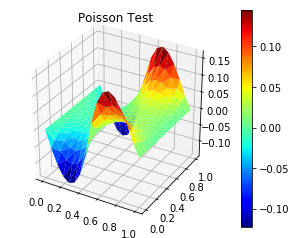

In [38]:
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline
    
fig = plt.figure()
p = dl.plot(u, title="Poisson Test", mode="warp")
fig.colorbar(p)
plt.show()

HTML(dl.X3DOM.html(u.cpp_object()))

# Heat System
Our interest is now on the time-dependent system:
\begin{equation}
\begin{aligned}
\partial_{t} u - \nabla^{2} u =  f & \text{ in } \Omega \times (0,T) \\
u = 0 & \text{ on } \Gamma_D \times (0,T) \\
\nabla u \cdot n = g & \text{ on } \Gamma_N \times (0,T) \\
u = u_{0} & \text{ on } \Omega \times \{t = 0\} 
\end{aligned}
\end{equation}

## Time approximation
By denoting $t_n$ an element the discretized interval $(0,T)$ associated to $u^n = u(t_n)$, we consider the approximation
\begin{equation}
\big( \partial_{t} u \big)^{n+1} \approx \frac{u^{n+1} - u^{n}}{\Delta t}
\end{equation}

It allows the implicit discretization of our system by
\begin{equation}
\begin{aligned}
u^0 & = u_0, \\
u^{n+1} - \Delta t \, \nabla^2 u^{n+1} & = u^{n} + \Delta t\, f^{n+1}, \quad n = 0, 1, 2, \dots
\end{aligned}
\end{equation}
Thus, obtaining the abstract formulation associated to $(u^n,v) \in V \times \hat{V}$ in the form:
\begin{equation}
F_{n+1}(u,v) := \int_{\Omega} u^{n+1}v + \Delta t\, \nabla u^{n+1}\cdot \nabla v - (u^{n} + \Delta t\, f^{n+1})v - \int_{\Gamma_N} \Delta t \, g v = 0 
\end{equation}
where at time $t = 0$ the solution is found to satisfy
\begin{equation}
a_0(u,v) := \int_{\Omega} \nabla u \cdot \nabla v = \int_{\Omega} f v + \int_{\Gamma_N} gv =: L_0(v)
\end{equation}

>``RECALL`` When solving this variational formulation, $u^0$ becomes the $L^2$ projection of the given initial value $u_0$ into the finite element space, i.e. $u^0 = \sum_{j=1}^N U^0_j \phi_j$ with $U_j = u_0(x_j, y_j)$ with such coordinates associated to the node $j$.

## Model Parameters
As before, we'll consider:
* A space domain $\Omega = [0,1]^2$ and time $t \in (0,T)$,
* Dirichlet boundary $\Gamma_D  =\{ (0, y) \cup (1,y) \subset \partial \Omega \}$,
* Neumann boundary $\Gamma_N = \{ (x, 0) \cup (x,1) \subset \partial \Omega \}$,
* A Neumann condition in the form $g = sin(5x)$,
* A source term $f(t) = t e^{-\frac{(x-0.5)^2+(y-0.5)^2}{0.02}}$ for $t \in (0,T)$.

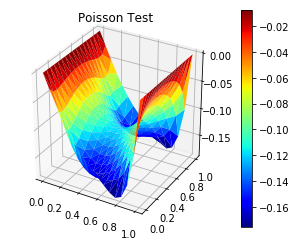


    At time 0.01, saved solution with L2 norm 0.107292

    At time 0.02, saved solution with L2 norm 0.093200

    At time 0.03, saved solution with L2 norm 0.081772

    At time 0.04, saved solution with L2 norm 0.072148

    At time 0.05, saved solution with L2 norm 0.063972

    At time 0.06, saved solution with L2 norm 0.057099

    At time 0.07, saved solution with L2 norm 0.051474

    At time 0.08, saved solution with L2 norm 0.047076

    At time 0.09, saved solution with L2 norm 0.043872

    At time 0.10, saved solution with L2 norm 0.041795

    At time 0.11, saved solution with L2 norm 0.040727

    At time 0.12, saved solution with L2 norm 0.040508

    At time 0.13, saved solution with L2 norm 0.040955

    At time 0.14, saved solution with L2 norm 0.041891

    At time 0.15, saved solution with L2 norm 0.043158

    At time 0.16, saved solution with L2 norm 0.044633

    At time 0.17, saved solution with L2 norm 0.046220

    At time 0.18, saved solution with L2 norm 0

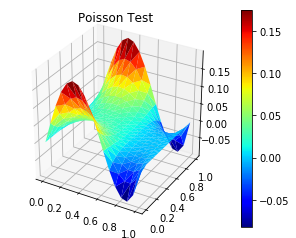


    At time 0.21, saved solution with L2 norm 0.052591

    At time 0.22, saved solution with L2 norm 0.054047

    At time 0.23, saved solution with L2 norm 0.055423

    At time 0.24, saved solution with L2 norm 0.056717

    At time 0.25, saved solution with L2 norm 0.057928

    At time 0.26, saved solution with L2 norm 0.059058

    At time 0.27, saved solution with L2 norm 0.060109

    At time 0.28, saved solution with L2 norm 0.061084

    At time 0.29, saved solution with L2 norm 0.061989

    At time 0.30, saved solution with L2 norm 0.062826

    At time 0.31, saved solution with L2 norm 0.063601

    At time 0.32, saved solution with L2 norm 0.064318

    At time 0.33, saved solution with L2 norm 0.064981

    At time 0.34, saved solution with L2 norm 0.065593

    At time 0.35, saved solution with L2 norm 0.066159

    At time 0.36, saved solution with L2 norm 0.066683

    At time 0.37, saved solution with L2 norm 0.067167

    At time 0.38, saved solution with L2 norm 0

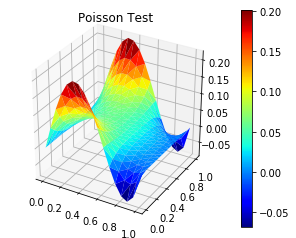


    At time 0.41, saved solution with L2 norm 0.068774

    At time 0.42, saved solution with L2 norm 0.069106

    At time 0.43, saved solution with L2 norm 0.069414

    At time 0.44, saved solution with L2 norm 0.069702

    At time 0.45, saved solution with L2 norm 0.069970

    At time 0.46, saved solution with L2 norm 0.070220

    At time 0.47, saved solution with L2 norm 0.070454

    At time 0.48, saved solution with L2 norm 0.070673

    At time 0.49, saved solution with L2 norm 0.070879

    At time 0.50, saved solution with L2 norm 0.071073

    At time 0.51, saved solution with L2 norm 0.071255

    At time 0.52, saved solution with L2 norm 0.071427

    At time 0.53, saved solution with L2 norm 0.071590

    At time 0.54, saved solution with L2 norm 0.071744

    At time 0.55, saved solution with L2 norm 0.071890

    At time 0.56, saved solution with L2 norm 0.072030

    At time 0.57, saved solution with L2 norm 0.072163

    At time 0.58, saved solution with L2 norm 0

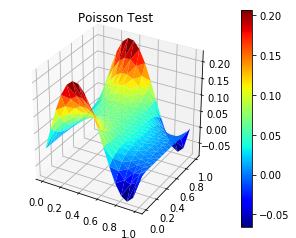


    At time 0.61, saved solution with L2 norm 0.072641

    At time 0.62, saved solution with L2 norm 0.072750

    At time 0.63, saved solution with L2 norm 0.072855

    At time 0.64, saved solution with L2 norm 0.072956

    At time 0.65, saved solution with L2 norm 0.073055

    At time 0.66, saved solution with L2 norm 0.073151

    At time 0.67, saved solution with L2 norm 0.073244

    At time 0.68, saved solution with L2 norm 0.073335

    At time 0.69, saved solution with L2 norm 0.073424

    At time 0.70, saved solution with L2 norm 0.073511

    At time 0.71, saved solution with L2 norm 0.073596

    At time 0.72, saved solution with L2 norm 0.073680

    At time 0.73, saved solution with L2 norm 0.073762

    At time 0.74, saved solution with L2 norm 0.073844

    At time 0.75, saved solution with L2 norm 0.073923

    At time 0.76, saved solution with L2 norm 0.074002

    At time 0.77, saved solution with L2 norm 0.074080

    At time 0.78, saved solution with L2 norm 0

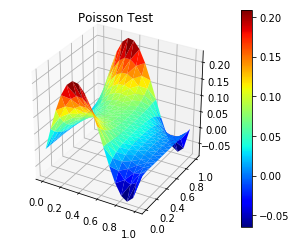


    At time 0.81, saved solution with L2 norm 0.074384

    At time 0.82, saved solution with L2 norm 0.074459

    At time 0.83, saved solution with L2 norm 0.074532

    At time 0.84, saved solution with L2 norm 0.074606

    At time 0.85, saved solution with L2 norm 0.074679

    At time 0.86, saved solution with L2 norm 0.074751

    At time 0.87, saved solution with L2 norm 0.074823

    At time 0.88, saved solution with L2 norm 0.074895

    At time 0.89, saved solution with L2 norm 0.074967

    At time 0.90, saved solution with L2 norm 0.075038

    At time 0.91, saved solution with L2 norm 0.075109

    At time 0.92, saved solution with L2 norm 0.075180

    At time 0.93, saved solution with L2 norm 0.075251

    At time 0.94, saved solution with L2 norm 0.075321

    At time 0.95, saved solution with L2 norm 0.075392

    At time 0.96, saved solution with L2 norm 0.075462

    At time 0.97, saved solution with L2 norm 0.075532

    At time 0.98, saved solution with L2 norm 0

In [5]:
import dolfin as dl
import time 
import matplotlib.pyplot as plt
%matplotlib inline

# Main parameters
T = 1 # Final time
num_steps = 100 # Num. steps
dt = T / num_steps # time-step

# Mesh Generation
mesh = dl.UnitSquareMesh(16, 16)

# Functional space
V = dl.FunctionSpace(mesh, 'Lagrange', 1)

# Boundary conditions
cpp_bdry = "(x[0] < DOLFIN_EPS || x[0] > 1. - DOLFIN_EPS) && on_boundary"
bc = dl.DirichletBC(V, dl.Constant(0.), cpp_bdry)

# Fixed functions
cpp_f = "t*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2))/0.02)"
f = dl.Expression(cpp_f, degree = 1, t = 0.1)
g = dl.Expression("sin(5*x[0])", degree = 1)

# Functions for variational formulation
u, v = dl.TrialFunction(V), dl.TestFunction(V)
u_n = dl.Function(V)

# Abstract formulation and linear system
F = u*v*dl.dx + dt*dl.inner(dl.grad(u), dl.grad(v))*dl.dx \
    - (u_n + dt*f)*v*dl.dx \
    - dt*g*v*dl.ds
a, L = dl.lhs(F), dl.rhs(F)

# Save solution for visualization and for matplotlib
vtk_file = dl.File('Heat_Sol/Diff_Hill.pvd')
solutions = []

# Time iteration
u = dl.Function(V)
u_n.assign(u_t0)
t = 0
for n in range(num_steps):
    # Update-time
    t += dt
    # Solve linear system
    dl.solve(a == L, u, bc)
    
    # Save results
    vtk_file << (u, t)
    
    if n % 20 == 0:
        fig = plt.figure()
        p = dl.plot(u, title="Poisson Test", mode="warp")
        fig.colorbar(p)
        plt.show()

    
    # Update solution at time n and save to list for plotting
    u_n.assign(u)
    f.t = t
    solutions.append(u.copy(deepcopy=True))
    
    print("""
    At time {:.2f}, saved solution with L2 norm {:4f}""".format(t, dl.norm(u, "L2")))

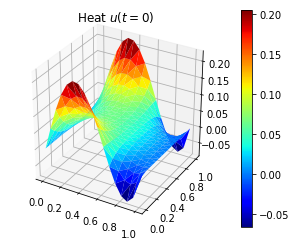

In [10]:
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline
    
#HTML(dl.X3DOM.html(u.cpp_object()))

# Create figure
fig = plt.figure()
p = dl.plot(solutions[50], title="Heat $u(t = 0)$", 
            mode="warp")
fig.colorbar(p)
plt.show()


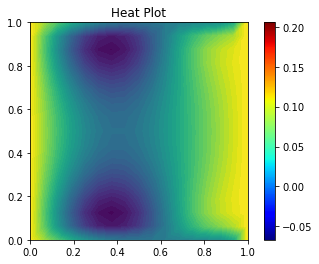

In [11]:
# Create animation
fig = plt.figure()
elem = dl.plot(solutions[0], title="Heat Plot")
fig.colorbar(p)
# Define animation (calling each frame)
def animate(id_frame):
    elem.set_array(solutions[id_frame])
    return (elem,)


#!ffmpeg -version
# Compile animation
#anim = animation.FuncAnimation(fig, animate, init_func=init, frames=50)
anim = animation.FuncAnimation(fig, animate, frames=100)
#anim.save('Heat_Animation.mp4')

In [15]:

#HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())

/bin/sh: 1: conda: not found


# Nonlinear example
By solving a nonlinear poisson problem

In [25]:
dl.set_log_level(20) # log info of general interest
import dolfin as dl


# Define subdomain with a python class
class DirichletBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - 1.) < dl.DOLFIN_EPS and on_boundary
    
# Create mesh
mesh = dl.UnitSquareMesh(32, 32)
# Functional space
V = dl.FunctionSpace(mesh, "CG", 1)

# Boundary conditions
g = dl.Constant(1.0)
cpp_code = "std::abs(x[0] - 1.0) < DOLFIN_EPS && on_boundary"
bc = dl.DirichletBC(V, g, cpp_code)

# Define variational problem
u, v = dl.Function(V), dl.TestFunction(V)
f = dl.Expression("x[0]*sin(x[1])", degree=1)
F = dl.inner((1 + u**2)*dl.grad(u), dl.grad(v))*dl.dx - f*v*dl.dx

# Compute solution with newton solver
dl.solve(F == 0, u, bc, solver_parameters={"newton_solver":
                                          {"relative_tolerance": 1e-6}})
         

            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.


            Calling FFC just-in-time (JIT) compiler, this may take some time.


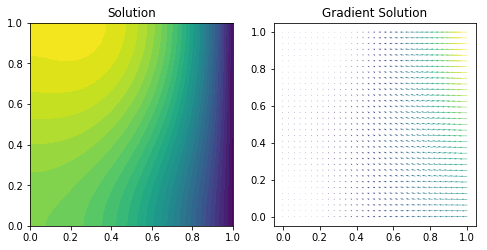

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
dl.plot(u, title="Solution")
plt.subplot(1, 2, 2)
dl.plot(dl.grad(u), title="Gradient Solution")

In [28]:
#from IPython.display import HTML
#HTML(dl.X3DOM.html(u.cpp_object()))